## Import the needed packages 

In [35]:
import pandas as pd 
import networkx as nt
import collections
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Import the data of the graph

In [36]:
data_user_user = pd.read_csv("./data/Social_spammers_dataset/graphs/c_combined_edges_w_1_s_0.9.csv")
data_user_app = pd.read_csv("./data/Social_spammers_dataset/graphs/app_based_similarity/app_user_interaction_graph/coded_weighted_edges.csv")
labels = pd.read_csv("./data/Social_spammers_dataset/users/coded_ids_labels_train.csv")

Let's see th overview of the graph data 

In [37]:
data_user_app.head()

,user_id,app_id,weight
0,1,23,9
1,1,33,391
2,362,200,192
3,362,23,8
4,488,176,61


In [38]:
data_user_user.head()

,Source,Target,Weight,Sim
0,1,168,30,0.975
1,4,56,13,0.974
2,149,244,12,1.000
3,198,244,4,1.000
4,1,244,16,1.000


Get label in dictionnary to facilitate the parsing

In [39]:
labels.head()
labels_dict=labels.to_dict() 

## Creation the graph from dataframe 
With networkx lib, we will build our graph. We will build two graph.
The first graph is a graph on the relationship between user.
The second one is about user and application used.

In [40]:
graph_user_app = nt.from_pandas_edgelist(data_user_app,source="user_id",target="app_id", edge_attr='weight')
graph_user_user = nt.from_pandas_edgelist(data_user_user,source="Source",target="Target", edge_attr='Sim')

# The metric of graph
In this section we will do the graph exploration by computing some metrics

In [41]:
print("Info graph user_app: ")
print(nt.info(graph_user_app))
print("Info graph user_app: ")
print(nt.info(graph_user_user))

Info graph user_app: 
Name: 
Type: Graph
Number of nodes: 767
Number of edges: 2021
Average degree:   5.2699
Info graph user_app: 
Name: 
Type: Graph
Number of nodes: 295
Number of edges: 1335
Average degree:   9.0508


### Computing the diameter and radius of the graph

In [42]:
print(f"radius of graph user app: {nt.radius(graph_user_app)}")
print(f"diameter of graph user app: {nt.diameter(graph_user_app)}")

radius of graph user app: 4
diameter of graph user app: 6


### Computing of the density of graph

In [43]:
density_user_user = nt.density(graph_user_user)
density_user_app = nt.density(graph_user_app)
print("The density of user_user_graph is {}".format(density_user_user))
print("The density of user_app_grap is {}".format(density_user_app))

The density of user_user_graph is 0.030785195434105846
The density of user_app_grap is 0.006879742375604658


### Degree ditribition analysis
Let'draw the histogram of degree distribution of our two graph

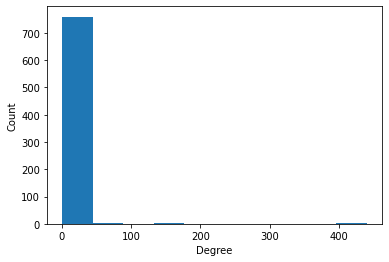

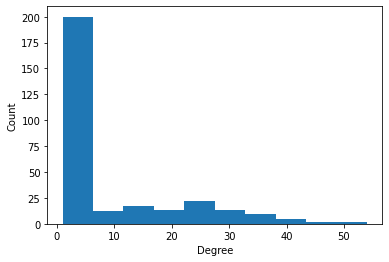

In [44]:
def plot_degree_dist(G,name):
    fig1 = plt.gcf()
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.ylabel("Count")
    plt.xlabel("Degree")
    plt.show()
    #plt.draw()
    fig1.savefig(name, dpi=100)

plot_degree_dist(graph_user_app, "graph_user_app_deg_dist.png")
plot_degree_dist(graph_user_user, "graph_user_user_deg_dist.png")


### Compute the distribution of degree only on one class
First, we will separate the node in two sets: one for the spammers and another one for the non spammer
And after that we will draw the degree distribution for each class of node.

In this section we also compute the mean of the degree on each class of node

In [45]:
#In this section we look for the spammer node and the non spammer node
list_spam = []
list_non_spam = []
for node in graph_user_user.nodes():   
    if labels_dict['label'].get(node) is not None:
        if labels_dict['label'].get(node) ==1:
            list_spam.append(node)
            
for node in graph_user_user.nodes():   
    if labels_dict['label'].get(node) is not None:
       if labels_dict['label'].get(node) ==0:
            list_non_spam.append(node)    

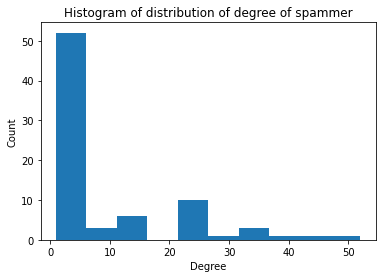

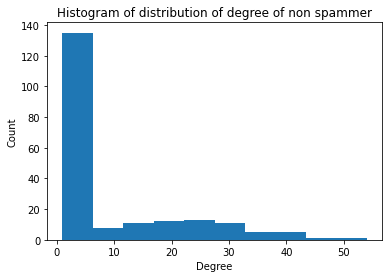

The mean of degree of the spammer: 9.692307692307692
The mean of degree of the non spammer: 9.178217821782178


In [46]:
import numpy as np
def plot_degree_dist(G, list_node, title, name_file):
    fig1 = plt.gcf()
    degrees = [G.degree(n) for n in list_node]
    plt.hist(degrees)
    plt.ylabel("Count")
    plt.xlabel("Degree")
    plt.title(title)
    plt.show()
    fig1.savefig(name_file, dpi=100)
    
plot_degree_dist(graph_user_user,list_spam,"Histogram of distribution of degree of spammer", "degr_spammer.png")
plot_degree_dist(graph_user_user,list_non_spam,"Histogram of distribution of degree of non spammer","degr_non_spa.png")


def compute_mean_of_degree(G, list_node):
    degrees = [G.degree(n) for n in list_node]
    return np.mean(degrees)

print ("The mean of degree of the spammer: {}".format(compute_mean_of_degree(graph_user_user,list_spam)))
print ("The mean of degree of the non spammer: {}".format(compute_mean_of_degree(graph_user_user,list_non_spam)))


We can constate that the mean of the degree of group of spammer is greater than the non spammer mean of degree
This observation allows us to say that the spammer share more edge than the non spammer.

Next, we will get the array of the degree for each class.

With these array, we will draw boxplot to see how it looks like.

In [47]:
degrees_spammer = [graph_user_user.degree(n) for n in list_spam]
degrees_non_spammer = [graph_user_user.degree(n) for n in list_non_spam]

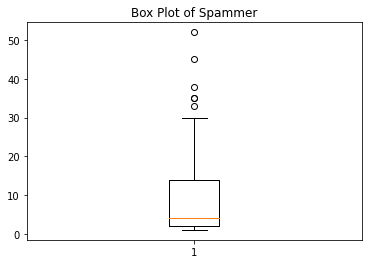

In [48]:
fig1, ax1 = plt.subplots()
ax1.set_title('Box Plot of Spammer')
ax1.boxplot(degrees_spammer)
fig1.savefig("boxplot_spam.png", dpi=100)

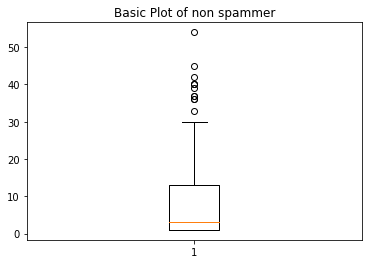

In [49]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot of non spammer')
ax1.boxplot(degrees_non_spammer)
fig1.savefig("boxplot_non_spam.png", dpi=100)

### Graph drawing
After computing some indicators, let dra the graphs of relationship between user

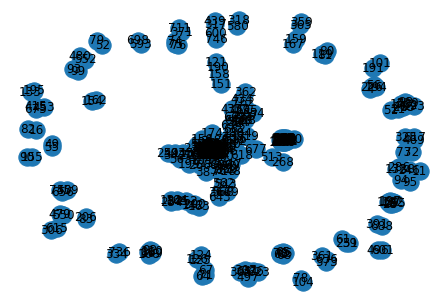

In [50]:
nt.draw(graph_user_user, with_labels=True)

In the previous figure, we can notice that this graph are not connected.

Let draw graph for app and user interaction

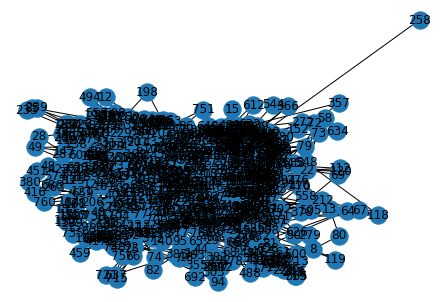

In [51]:
nt.draw(graph_user_app, with_labels=True)

Let compute the degree of centrality of each node 

In [52]:
degree_dict_user_user = nt.degree_centrality(graph_user_user)
degree_dict_user_app = nt.degree_centrality(graph_user_app)

After computing the degree of centrality of each 

In [53]:
print("The mean of the degree of centrality for the user relation graph is {}".format(np.mean([item for item in degree_dict_user_user.values()])))
print("The mean of the degree of centrality for the user interaction with app graph is {}".format(np.mean([item for item in degree_dict_user_app.values()])))

The mean of the degree of centrality for the user relation graph is 0.030785195434105843
The mean of the degree of centrality for the user interaction with app graph is 0.006879742375604658


Now, we will compute this mean with this mean for only the spammer and only for the non-spammer

In [54]:

list_to_compute_mean =[]
for node in degree_dict_user_user:   
    if labels_dict['label'].get(node) is not None:
        if labels_dict['label'].get(node) ==1:
            list_to_compute_mean.append(degree_dict_user_user[node])
print(" The mean of the centrality of spammer : {}".format(np.mean(list_to_compute_mean) ))       



list_to_compute_mean =[]
for node in degree_dict_user_user:   
    if labels_dict['label'].get(node) is not None:
        if labels_dict['label'].get(node) ==0:
            list_to_compute_mean.append(degree_dict_user_user[node])
print(" The mean of the centrality of non spammer : {}".format(np.mean(list_to_compute_mean) ))       


 The mean of the centrality of spammer : 0.03296703296703297
 The mean of the centrality of non spammer : 0.0312184279652455


The mean of centrality of the spammer is pretty greater than the non spammer.

## Computing of the betweenness of each node
More easily, this metric will show the best_connector

In [55]:
betweeness_user_user = nt.betweenness_centrality(graph_user_user)

In [56]:
betweeness_user_user = dict(sorted(betweeness_user_user.items(), key=lambda item: item[1],reverse=True))

Let compute the mean of betweeness by class of node.


In [57]:

list_to_compute_mean =[]
for node in betweeness_user_user:   
    if labels_dict['label'].get(node) is not None:
        if labels_dict['label'].get(node) ==1:
            list_to_compute_mean.append(betweeness_user_user[node])
print(" The mean of the betweeness of spammer : {}".format(np.mean(list_to_compute_mean) ))       



list_to_compute_mean =[]
for node in betweeness_user_user:   
    if labels_dict['label'].get(node) is not None:
        if labels_dict['label'].get(node) ==0:
            list_to_compute_mean.append(betweeness_user_user[node])
print(" The mean of the betweeness of non spammer : {}".format(np.mean(list_to_compute_mean) ))       


 The mean of the betweeness of spammer : 0.0016196661726249728
 The mean of the betweeness of non spammer : 0.001884250561132695


### Computing of average of clustering coefficient

In [58]:
average_clustering_user_user = nt.average_clustering(graph_user_user)
average_clustering_user_app = nt.average_clustering(graph_user_app)
print ("The average of clustering coefficient of graph user relation is {}".format(average_clustering_user_user))
print ("The average of clustering coefficient of graph user app is {}".format(average_clustering_user_app))

The average of clustering coefficient of graph user relation is 0.47837313796999104
The average of clustering coefficient of graph user app is 0.17656147836380048


From the previous indicators, the graph on user relationship is mre clustable than the other graph.

In [59]:
closeness_user_user = nt.closeness_centrality(graph_user_user)

In [60]:
closeness_user_user = dict(sorted(closeness_user_user.items(), key=lambda item: item[1],reverse=True))

In [61]:
list_to_compute_mean_spam =[]
for node in closeness_user_user:   
    if labels_dict['label'].get(node) is not None:
        if labels_dict['label'].get(node) ==1:
            list_to_compute_mean_spam.append(closeness_user_user[node])
list_to_compute_mean_non_spam =[]
for node in closeness_user_user:   
    if labels_dict['label'].get(node) is not None:
        if labels_dict['label'].get(node) ==0:
            list_to_compute_mean_non_spam.append(closeness_user_user[node])
print("the mean of clossness of spammmer {}",np.mean(list_to_compute_mean_spam))
print("the mean of clossness of non spammmer {}",np.mean(list_to_compute_mean_non_spam))

the mean of clossness of spammmer {} 0.08221274876513192
the mean of clossness of non spammmer {} 0.08526386823516259


## Link analysis

Analysis of the influence. The interpretation of this metric is influence of on node in the nerwork.
At the end, we will display orded in most influenced node

In [62]:
most_influential_link = nt.degree_centrality(graph_user_user)

In [63]:
#Adding the label
for item in most_influential_link:
    most_influential_link[item]=(most_influential_link[item],labels_dict['label'].get(item))

In [64]:
most_influential_link

{1: (0.0782312925170068, 0),
 168: (0.0782312925170068, 0),
 4: (0.01020408163265306, 0),
 56: (0.01020408163265306, 1),
 149: (0.0782312925170068, 0),
 244: (0.0782312925170068, 0),
 198: (0.07142857142857142, 0),
 48: (0.0782312925170068, 1),
 25: (0.0782312925170068, 1),
 232: (0.0782312925170068, 1),
 185: (0.0782312925170068, 0),
 34: (0.0782312925170068, 0),
 229: (0.07482993197278912, 0),
 239: (0.0782312925170068, 0),
 238: (0.0782312925170068, 0),
 260: (0.07482993197278912, 0),
 170: (0.0782312925170068, 1),
 18: (0.0782312925170068, 0),
 196: (0.0782312925170068, 0),
 91: (0.07482993197278912, 0),
 237: (0.0782312925170068, 0),
 233: (0.07482993197278912, 0),
 183: (0.0782312925170068, 0),
 236: (0.0782312925170068, 0),
 251: (0.057823129251700675, 0),
 122: (0.07482993197278912, 1),
 60: (0.01020408163265306, 1),
 434: (0.006802721088435374, 0),
 362: (0.003401360544217687, 0),
 588: (0.02040816326530612, 0),
 654: (0.003401360544217687, 0),
 636: (0.003401360544217687, 0),

### Page rank 

In [65]:
page_rank=nt.pagerank(graph_user_user)

In [66]:
# the max page_rank
import operator
max_page_rank =max(page_rank.items(), key=operator.itemgetter(1))[0]

Let show the most page_rank node label

In [67]:
labels_dict['label'].get(max_page_rank)

1

Let compute the most important connection and its label.
A node is high eigenvector centrality if it is connected to many other nodes who are themselves well connected.

In [68]:
most_important_linked = nt.eigenvector_centrality(graph_user_user)
for w in sorted(most_important_linked, key=most_important_linked.get, reverse=True):
    print(w, most_important_linked[w],labels_dict['label'].get(w))

240 0.2053466952222802 0
137 0.20007116848212567 1
33 0.19154650519803795 0
136 0.1909179357115181 1
257 0.18913960441815067 0
223 0.1854685477854571 0
267 0.184522637831872 0
463 0.18053552510982565 0
241 0.18025828236593705 0
17 0.17975094125267083 0
309 0.17871080448385593 0
138 0.17855792713103996 1
102 0.17751294016727323 0
220 0.17610722180229607 1
227 0.17572087152285287 1
315 0.17305508234998443 0
87 0.1673617222558742 1
129 0.165456219042618 1
24 0.16508280456663757 0
19 0.16442889817403766 0
321 0.1632908182716344 0
36 0.16319740038215153 0
77 0.16247034730217846 0
293 0.1620276394155314 0
407 0.1620276394155314 0
338 0.1620276394155314 0
572 0.1620276394155314 0
699 0.1620276394155314 None
310 0.1620276394155314 0
144 0.11644179683910402 0
3 0.0954316217246763 1
147 0.0835613178730317 1
9 0.07514771535461261 1
179 0.07412283959669377 0
218 0.07225992987879216 1
205 0.06524922912369609 0
295 0.06357106804428977 0
282 0.06357106804428977 0
187 0.05847455461140565 0
207 0.05728

#### Detection of community with girvan_newman on user relationship grah

In [69]:
from networkx.algorithms import community
communities_generator = community.girvan_newman(graph_user_user)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
coun = 0
print("The number of community with girvan_newman is : ", len(sorted(map(sorted, next_level_communities))))
for arr in sorted(map(sorted, next_level_communities)):
    #print("In the community {} there are {} there are follwoing node :".format(coun, len(arr)))
    for node in arr:
        pass
        #print(node)
    coun =coun+1

The number of community with girvan_newman is :  47


Generation of graph bipartite

In [70]:
from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection

print(kernighan_lin_bisection(graph_user_user))

({516, 9, 11, 17, 529, 19, 532, 21, 23, 24, 33, 547, 36, 552, 45, 559, 562, 51, 563, 568, 59, 572, 573, 60, 64, 66, 580, 68, 70, 584, 73, 74, 75, 76, 77, 78, 79, 588, 593, 82, 83, 86, 87, 600, 601, 90, 92, 99, 102, 615, 105, 106, 618, 110, 623, 114, 634, 124, 636, 129, 641, 132, 136, 138, 145, 146, 147, 154, 668, 159, 163, 677, 169, 171, 172, 687, 688, 179, 180, 182, 698, 699, 187, 195, 197, 711, 199, 201, 204, 205, 211, 215, 218, 220, 223, 737, 226, 738, 740, 228, 227, 231, 746, 240, 241, 250, 254, 257, 261, 264, 266, 267, 269, 286, 293, 295, 306, 309, 310, 315, 317, 319, 321, 325, 338, 350, 361, 362, 365, 377, 384, 387, 391, 407, 411, 415, 424, 435, 439, 444, 448, 453, 462, 463, 465, 469, 479}, {513, 1, 3, 4, 8, 10, 16, 18, 530, 20, 533, 25, 26, 27, 30, 543, 31, 34, 35, 550, 38, 41, 42, 43, 47, 48, 49, 52, 53, 55, 56, 57, 570, 61, 63, 65, 67, 71, 72, 80, 81, 84, 89, 91, 93, 94, 607, 95, 98, 101, 103, 104, 617, 108, 109, 119, 121, 122, 125, 126, 130, 643, 133, 646, 648, 137, 654, 142,

### Detection of community with k-clique
With k=3, we will detect the communities

In [71]:
communities_generator = nt.community.k_clique_communities(graph_user_user, 3)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
print(next_level_communities)

frozenset({56, 194, 226, 4})


## Clustering based on simularity

Now let'use K-means to do clustering. This part is inspired from [link](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) 

We will use k-means with differents configuration after that, we will compute some metric to evalute the cluster 

In [72]:
filepath ="./data/Social_spammers_dataset/graphs/app_based_similarity/sim_matrix.txt"
matrix = open(filepath).read()
matrix = [item.split(",") for item in matrix.split('\n')[:-1]]

In [73]:
matrix_np = np.array(matrix)
matrix_np = matrix_np.astype(np.float32)

In [74]:
columns = [ index for index in range(1,768) ]
rows = [ index for index in range(1,768) ]
dataframe_from_sim_matrix = pd.DataFrame(data=matrix_np, index=rows, columns=columns)

In [75]:
from sklearn.cluster import KMeans

## Setting our benchmarck
This code allows us to make comparaision beetween the variants of k-means, and adding PCA

In [76]:

def bench_k_means(kmeans, name, data, labels):
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(data, estimator[-1].labels_,
                                 metric="euclidean", sample_size=300,)
    ]

    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [77]:

def benchmark_k_mean(dataframe,labels):
    for i in range(2,10):
        print ("With K = {}".format(i))
        print(82 * '_')
        print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

        kmeans = KMeans(init="k-means++", n_clusters=i, n_init=4,
                        random_state=0)
        bench_k_means(kmeans=kmeans, name="k-means++", data=dataframe, labels=labels)

        kmeans = KMeans(init="random", n_clusters=i, n_init=4, random_state=0)
        bench_k_means(kmeans=kmeans, name="random", data=dataframe, labels=labels)

        pca = PCA(n_components=i).fit(dataframe)
        kmeans = KMeans(init=pca.components_, n_clusters=i, n_init=1)
        bench_k_means(kmeans=kmeans, name="PCA-based", data=dataframe, labels=labels)

        print(82 * '_')


### The matrix from sim_matrix.txt 

In [78]:
dataframe_from_sim_matrix.shape

(767, 767)

### Clustering of the data from sim matrix
In this section we will make cluster(community) with the file.

In [79]:
benchmark_k_mean(dataframe_from_sim_matrix,[index for index in range(1,768)])

With K = 2
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.116s	378817	0.102	1.000	0.185	0.000	0.000	0.581
random   	0.096s	378817	0.102	1.000	0.185	0.000	0.000	0.586
PCA-based	0.046s	378817	0.102	1.000	0.185	0.000	0.000	0.562
__________________________________________________________________________________
With K = 3
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.145s	291944	0.157	1.000	0.271	0.000	-0.000	0.570
random   	0.063s	291944	0.157	1.000	0.271	0.000	-0.000	0.549
PCA-based	0.026s	291944	0.157	1.000	0.271	0.000	-0.000	0.589
__________________________________________________________________________________
With K = 4
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.080s	2478

From the matrix file, we made clusters (communities). For the K=9, that is the best number of K according to the silhouette metric 

##  Now we will do the clustering with the matrix from the graph user interaction
We also apply a clustering algorithm ( k-means, hierarchical algorithms).
we also generated the matrix with simarilty from graph of user relationship.

In [80]:
graph_user_user_matrix = nt.adjacency_matrix(graph_user_user,weight='Sim')

In [81]:
print(graph_user_user_matrix.todense())
labels = graph_user_user.nodes()
graph_user_user_matrix = pd.DataFrame(graph_user_user_matrix.todense(), index=list(labels), columns=list(labels))

[[0.    0.975 0.    ... 0.    0.    0.   ]
 [0.975 0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]


Let  show the shape on second matrix

In [82]:
graph_user_user_matrix.shape

(295, 295)

In [83]:
graph_user_user_matrix

,1,168,4,56,149,244,198,48,25,232,...,167,365,359,319,199,439,317,174,677,193
1,0.000,0.975,0.000,0.000,1.000,1.000,1.000,1.000,0.999,0.943,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0
168,0.975,0.000,0.000,0.000,0.971,0.971,0.971,0.971,0.982,0.982,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0
4,0.000,0.000,0.000,0.974,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0
56,0.000,0.000,0.974,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0
149,1.000,0.971,0.000,0.000,0.000,1.000,1.000,1.000,0.998,0.936,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.000,0.927,0.0,0.0,0.0
317,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.927,0.000,0.0,0.0,0.0
174,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0
677,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0


In [84]:
benchmark_k_mean(graph_user_user_matrix,graph_user_user.nodes())

With K = 2
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.035s	79735	0.059	1.000	0.112	0.000	-0.000	0.493
random   	0.028s	79735	0.059	1.000	0.112	0.000	-0.000	0.493
PCA-based	0.027s	79735	0.059	1.000	0.112	0.000	-0.000	0.493
__________________________________________________________________________________
With K = 3
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.047s	73186	0.106	1.000	0.191	0.000	-0.000	0.481
random   	0.030s	78451	0.076	1.000	0.142	0.000	-0.000	0.095
PCA-based	0.010s	73171	0.107	1.000	0.193	0.000	-0.000	0.481
__________________________________________________________________________________
With K = 4
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.022s	71016	0

The best silhouette is obtained when we uses k as 2 .
Let draw to get more insight about these clusters.

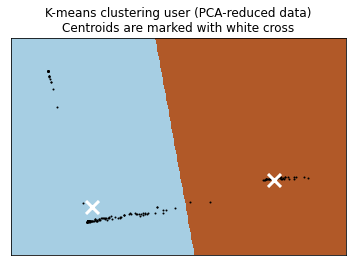

In [85]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(graph_user_user_matrix)
kmeans = KMeans(init="k-means++", n_clusters=2, n_init=4)
kmeans.fit(reduced_data)

h = .02 
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
#plt.figure(figsize=(200,100))
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering user (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.show()

## Hierarchical Clustering
To end this study let uild the dendogram from Hierarchical Clustering

The following section will compute the cluster from the graph matrix of simularity.
From the previous section the right number of cluster is 2 for this matrix

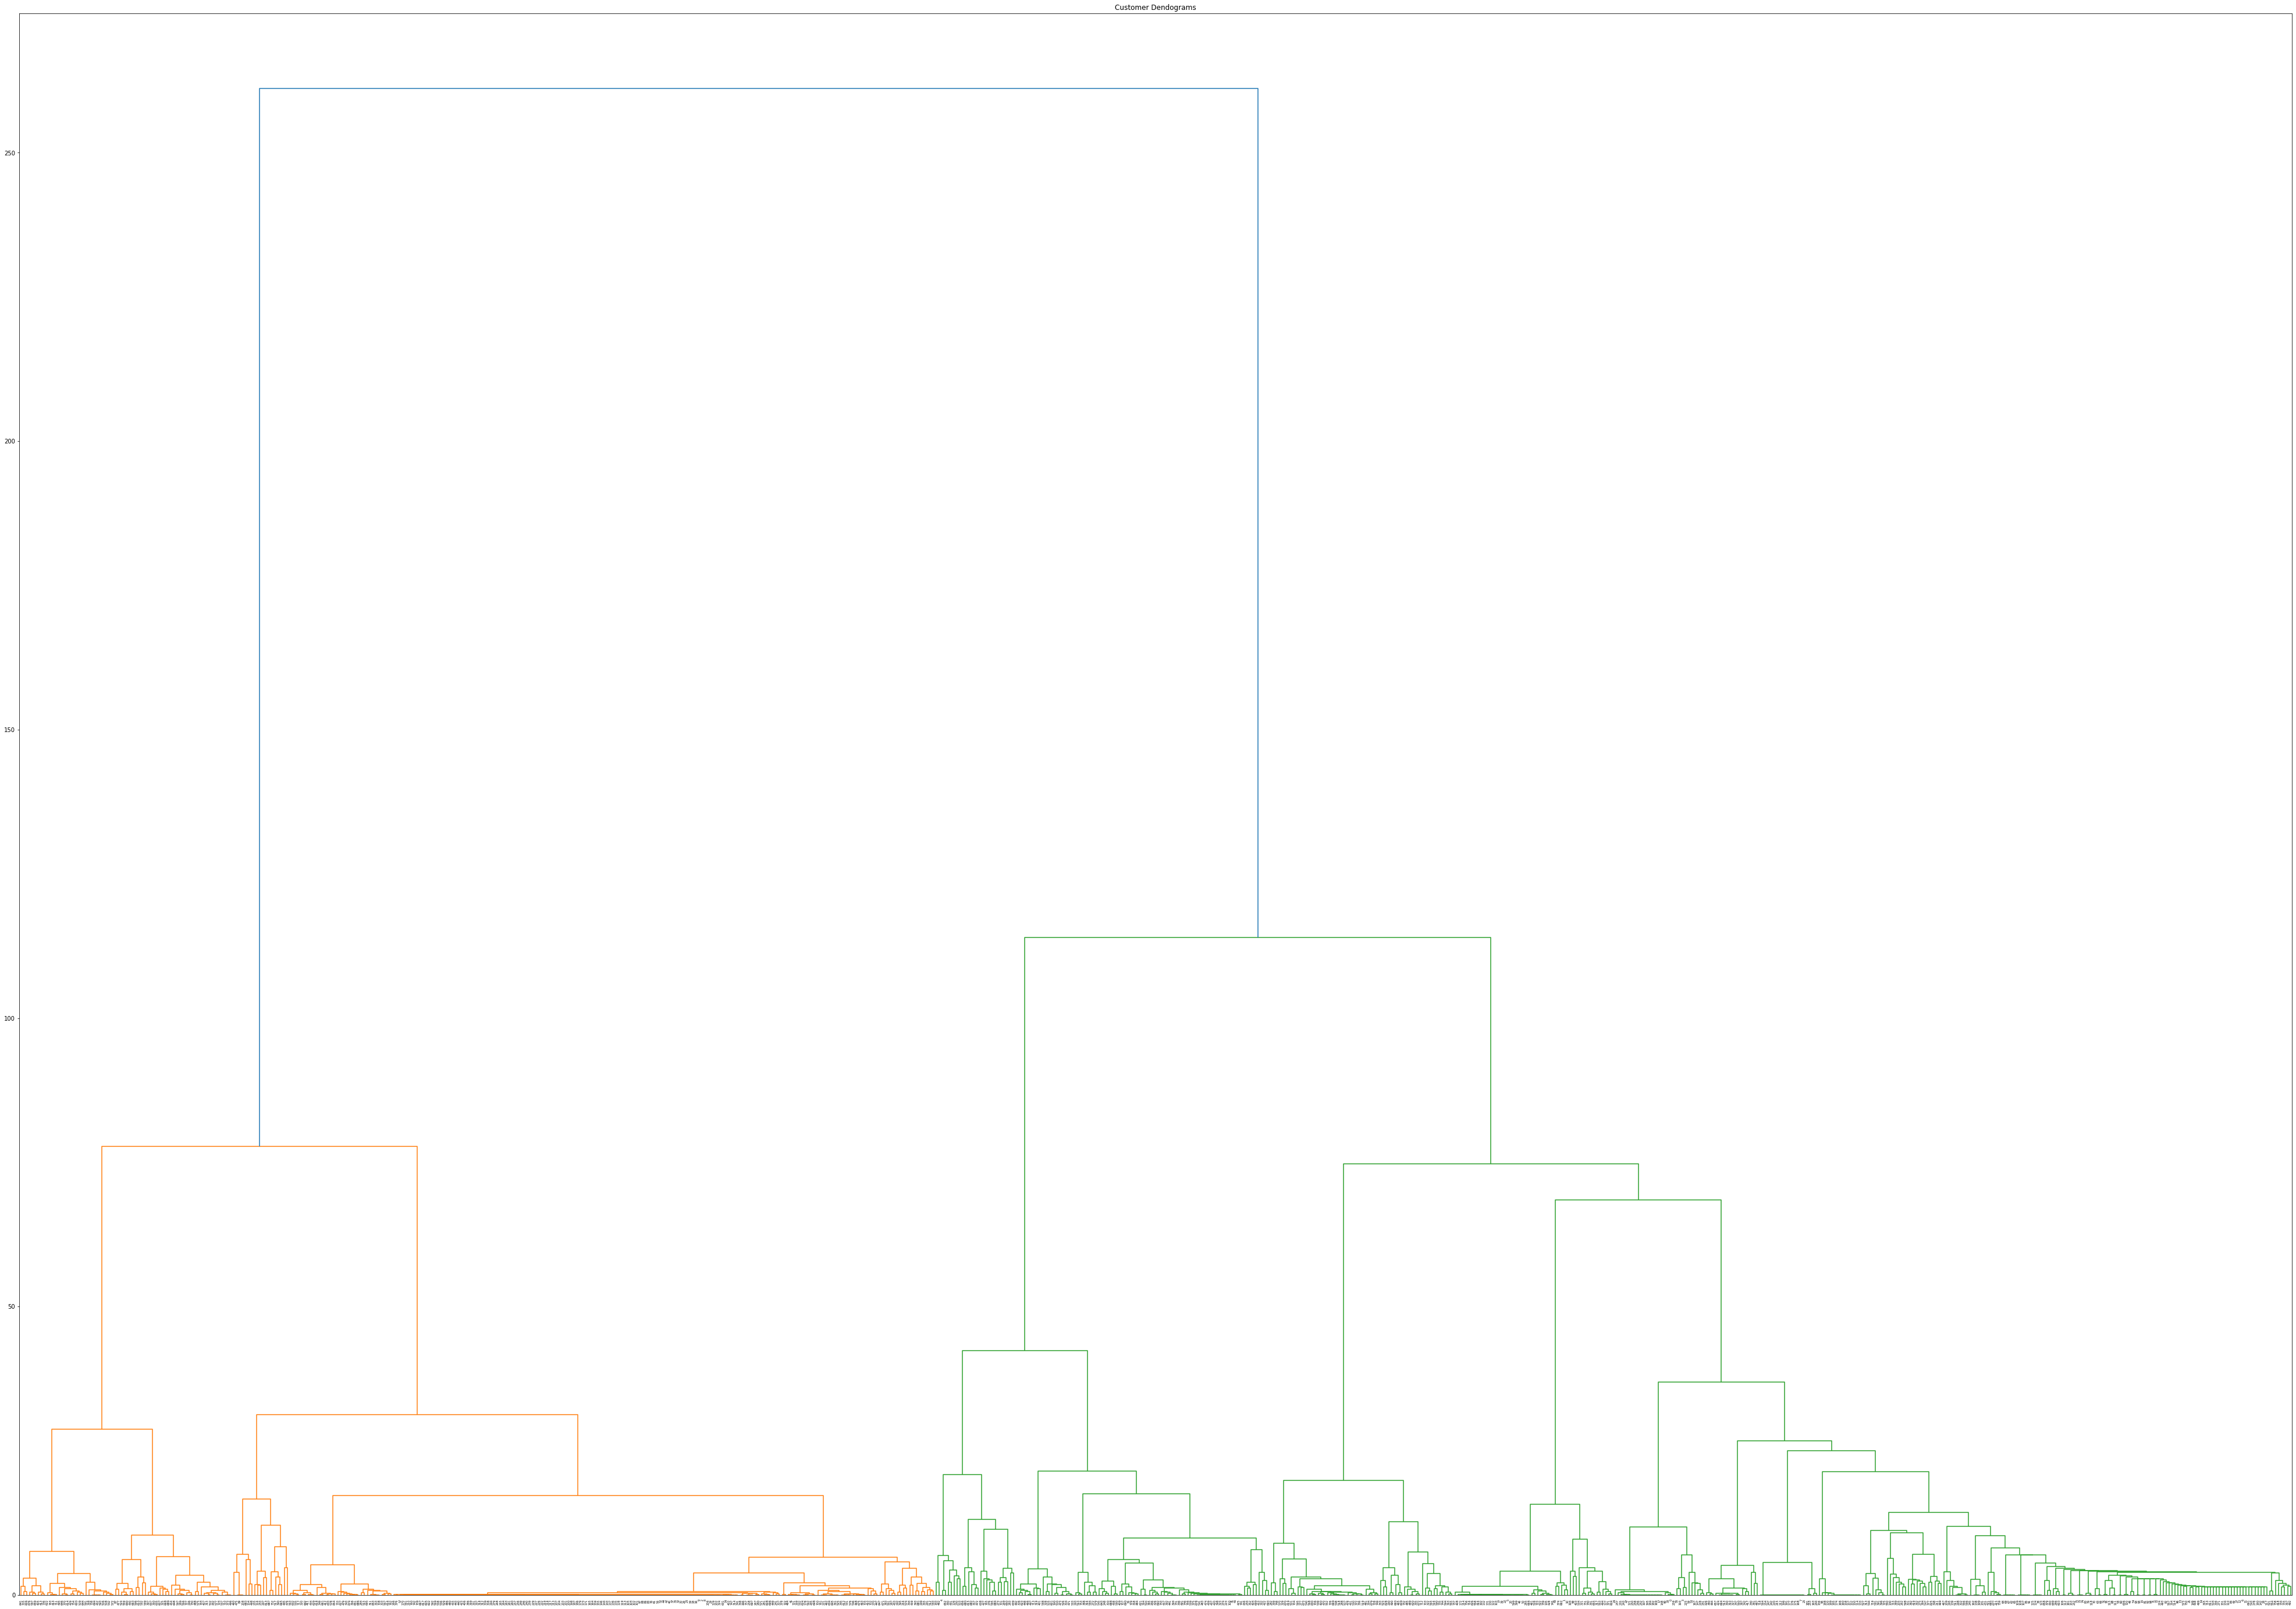

In [86]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(70, 50))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(dataframe_from_sim_matrix, method='ward'))

This section will compute the cluter from the sim_matrix.txt file.

Let's build the dendogram before make cluster.

According to the dendogram, the value 2 is right for the number of cluster.

In [87]:
from sklearn.cluster import AgglomerativeClustering

cluster_AgglomerativeClustering = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster_AgglomerativeClustering.fit_predict(dataframe_from_sim_matrix)

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,

We call add this group to the dataset for the prediction task for the spammer. 
We think that can improve the accuracy of model.

Let build the dendogram of this two dataset

<ipython-input-88-7e1709bf5820>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dend = shc.dendrogram(shc.linkage(graph_user_user_matrix, method='ward'))


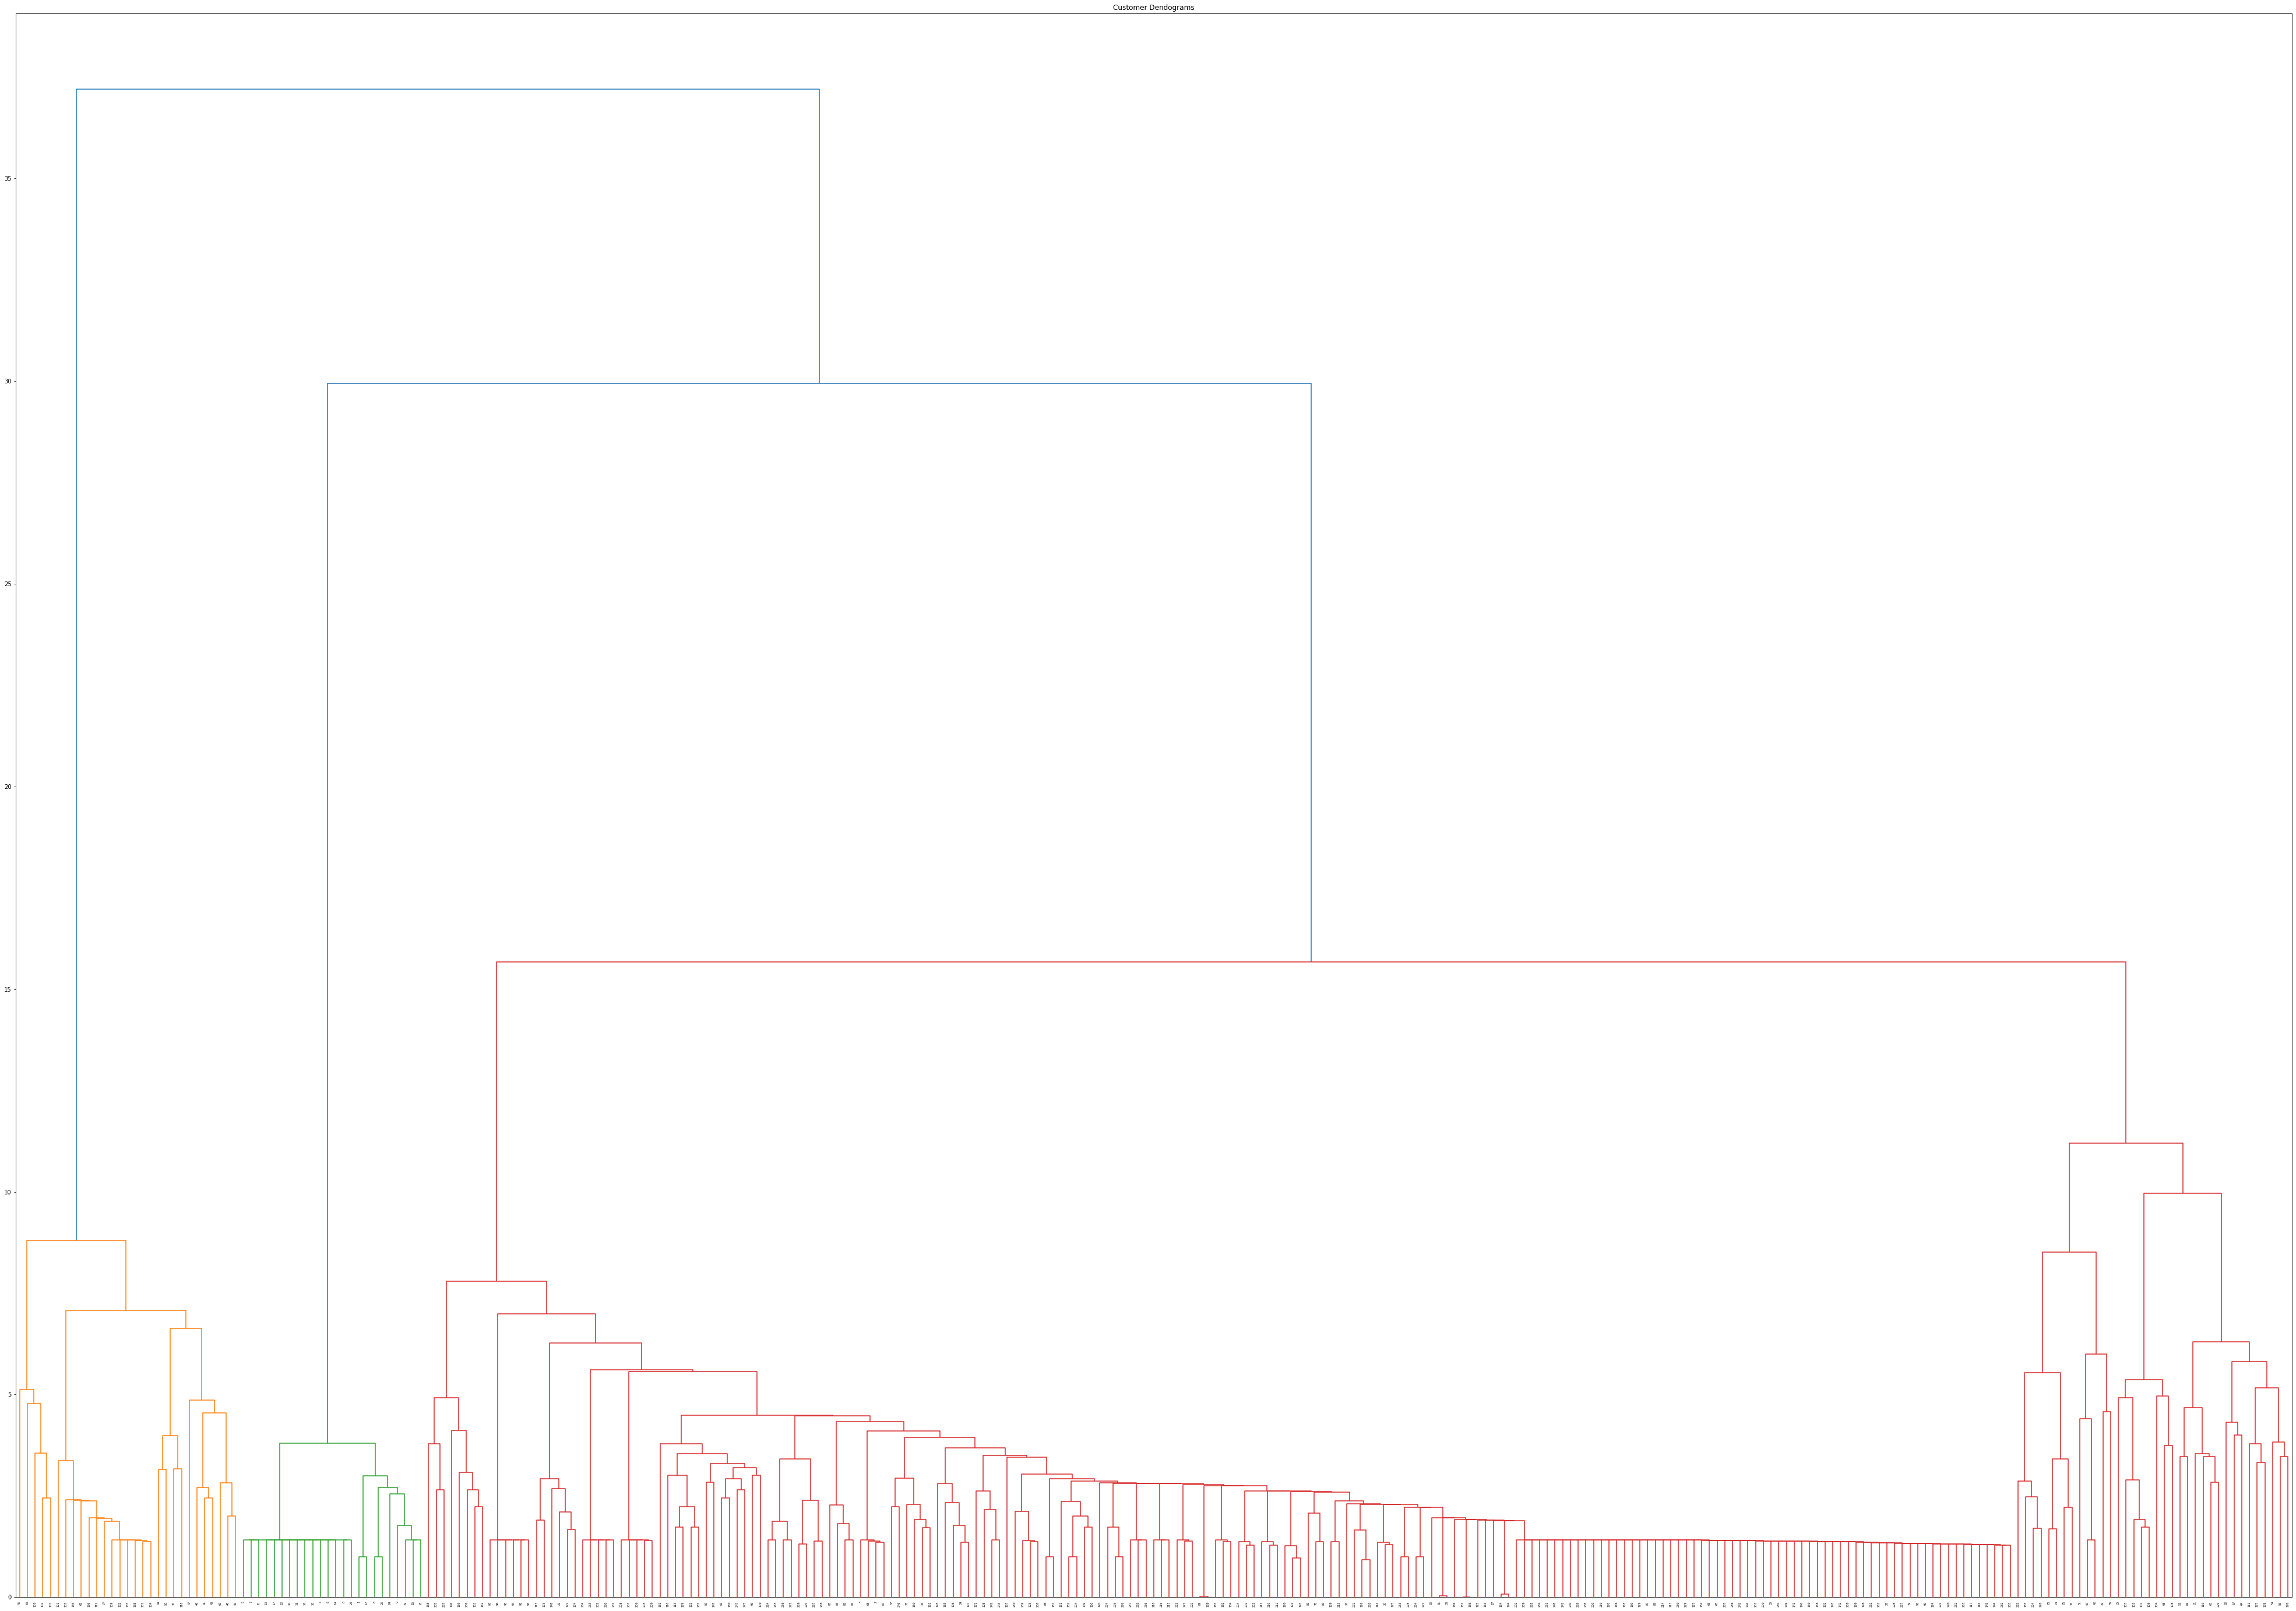

In [88]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(70, 50))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(graph_user_user_matrix, method='ward'))

In [89]:
from sklearn.cluster import AgglomerativeClustering

cluster_AgglomerativeClustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster_AgglomerativeClustering.fit_predict(graph_user_user_matrix)

/home/abou/anaconda3/envs/tf/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])